In [1]:
import numpy as np
import pickle

from gpu import set_gpu
from matplotlib import pyplot as plt
import loop as lp
set_gpu()

Num GPUs Available:  1


In [2]:
sub_type = 'TR'
with open('train_data_raw_'  + sub_type + '.p', 'rb') as f:
    raw, params,feat,feat_sq = pickle.load(f)

In [8]:
# Loop through noise
# acc_all, acc_noise, acc_clean, file_name = lp.loop_sub(raw, params, sub_type, load=True, n_train='fullgaussflat4', train_scale=5, n_test='fullflat1',test_scale=0,epochs=30, sparsity=True,dt='manual',feat_type='feat')
acc_all, acc_noise, acc_clean, file_name = lp.loop_noise(raw, params, sub_type, load=False, n_train='fullgaussflat4', train_scale=5, n_test=0,epochs=10, batch_size = 128, sparsity=True,dt='cv',feat_type='raw',noise=True, latent_dim=200)

========================] - 5s 282us/sample - loss: 1.1252 - decoder_loss: 0.1802 - clf_loss: 0.8876 - val_loss: 2.1710 - val_decoder_loss: 0.2714 - val_clf_loss: 1.8380
Train on 18900 samples, validate on 6300 samples
Epoch 1/10
18900/18900 [==============================] - 2s 84us/sample - loss: 1.9649 - val_loss: 1.9499
Epoch 2/10
18900/18900 [==============================] - 1s 46us/sample - loss: 1.9459 - val_loss: 1.9498
Epoch 3/10
18900/18900 [==============================] - 1s 47us/sample - loss: 1.9348 - val_loss: 1.9499
Epoch 4/10
18900/18900 [==============================] - 1s 46us/sample - loss: 1.9018 - val_loss: 1.9545
Epoch 5/10
18900/18900 [==============================] - 1s 46us/sample - loss: 1.8624 - val_loss: 2.0006
Epoch 6/10
18900/18900 [==============================] - 1s 47us/sample - loss: 1.8243 - val_loss: 2.1342
Epoch 7/10
18900/18900 [==============================] - 1s 48us/sample - loss: 1.7942 - val_loss: 2.1782
Epoch 8/10
18900/18900 [========

In [4]:
sub_all = acc_all[0,...]
sub_clean = acc_clean[0,...]
sub_noise = acc_noise[0,...]

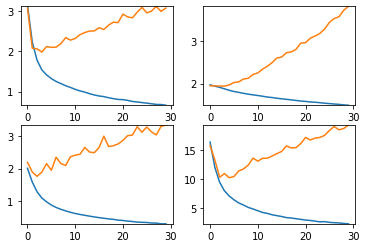

In [6]:
train_grp = 2
dt = 'cv'
feat_type = 'raw'
latent_dim = 60
epochs = 30
n_train = 'fullgaussflat4'
train_scale = 5
foldername = 'models' + '_' + str(train_grp) + '_' + dt
batch_size = 128
n_test = 0

loss = np.zeros((4,4,epochs))
val_loss = np.zeros((4,4,epochs))

for sub in range(1,2):#6):
    for cv in range(1,5):
        filename = foldername + '/' + sub_type + str(sub) + '_' + feat_type + '_dim_' + str(latent_dim) + '_ep_' + str(epochs) + '_bat_' + str(batch_size) + '_' + n_train + '_' + str(train_scale) + '_cv_'+ str(cv) + '_sparse'
        with open(filename + '_hist.p', 'rb') as f:
            svae_hist, sae_hist, cnn_hist, vcnn_hist = pickle.load(f)
        loss[cv-1,...] = np.array([svae_hist['loss'], sae_hist['loss'], cnn_hist['loss'], vcnn_hist['loss']])
        val_loss[cv-1,...] = np.array([svae_hist['val_loss'], sae_hist['val_loss'], cnn_hist['val_loss'], vcnn_hist['val_loss']])

    resultsfile = filename
    with open(resultsfile + '_results.p', 'rb') as f:
        acc_all, acc_clean, acc_noise = pickle.load(f)

    ave_loss = np.mean(loss,axis=0)
    ave_val = np.mean(val_loss,axis=0)

    plt.figure(sub)
    for i in range(0,4):
        ax = plt.subplot(2,2,i+1)
        ax.plot(ave_loss[i])
        ax.plot(ave_val[i])
        ax.set_ylim(np.min(ave_loss[i]),np.max(ave_val[i]))
        # if i < 3:
        #     ax.set_ylim(0,1.5)
        # else:
        #     ax.set_ylim(0,0.4)

In [6]:
# Load noise results
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='fullpos5', latent_dim=4,loop_i='noise', dt='manual')
sub_all, sub_noise, sub_clean, flat_ave_all, flat_ave_noise, flat_ave_clean = lp.ave_results(params, sub_type, train_grp=2, feat_type='feat',epochs=30,n_train='fullgaussflat4',train_scale=5,n_test='fullflat1', latent_dim=4,loop_i='noise',dt='manual')

FileNotFoundError: [Errno 2] No such file or directory: 'models_2_manual/TR_feat_dim_4_ep_30_fullgaussflat4_5_fullpos5_sparse_results.p'

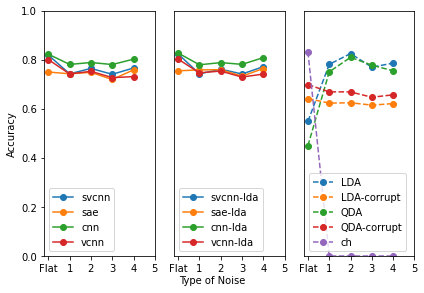

In [17]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    _ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(4,8):    
    ax[1].plot(np.hstack((flat_ave_noise[:,i],ave_noise[:,i])),'-o')
for i in range(8,13):    
    ax[2].plot(np.hstack((flat_ave),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

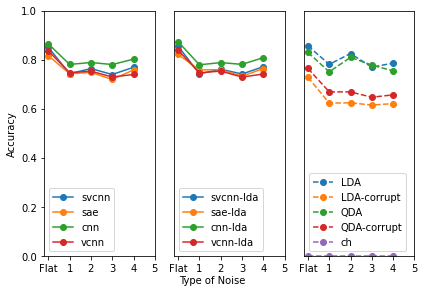

In [18]:
# Plot accuracy vs. noise
fig,ax = plt.subplots(1,3)
for i in range(0,4):
    ax[0].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(4,8):    
    ax[1].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'-o')
for i in range(8,13):    
    ax[2].plot(np.hstack((flat_ave_clean[:,i],ave_clean[:,i])),'--o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0, 'Type of Noise', ha='center')
ax[0].legend(['svcnn','sae','cnn','vcnn'])
ax[1].legend(['svcnn-lda','sae-lda','cnn-lda','vcnn-lda'])
ax[2].legend(['LDA','LDA-corrupt','QDA','QDA-corrupt','ch'])
ax[1].set_yticks([])
ax[2].set_yticks([])
for i in range(0,3):
    ax[i].set_ylim(0,1)
    ax[i].set_xticks(range(0,6))
    ax[i].set_xticklabels(['Flat','1','2','3','4','5'])

fig.set_tight_layout(True)

## Removing Noisy Channels Loop

In [5]:
test = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
al = np.squeeze(test)

In [ ]:
# Index subject and training group
num_ch = int(n_type[-1]) + 1
full_type = n_type[0:4]
noise_type = n_type[4:-1]

# tile data once for each channel
if full_type == 'full':
    start_ch = 1
# tile data twice, once for clean and once for noise
elif full_type == 'part':
    start_ch = num_ch - 1

acc_all = np.zeros(num_ch-start_ch)
# loop through channel noise
for num_noise in range(start_ch,num_ch):
    ch_all = list(combinations(range(0,6),num_noise))
    ch_split = temp.shape[0]//len(ch_all)
    acc_ch = np.zeros(len(ch_all))
    for ch in range(0,len(ch_all)):
        temp = x[ch*ch_split:(ch+1)*ch_split,:,:]
        y_test = y[ch*ch_split:(ch+1)*ch_split,:]
        mask = np.ones(temp.shape[1],dtype=bool)
        for i in ch_all[ch]:
            mask[i] = 0
        maskmu = np.tile(mask,4)
        test_data = temp[:,mask,:]
        w_temp, c_temp = train_lda(test_data,label,mu_bool = True, mu[maskmu], mu_class[:,maskmu], C[maskmu,maskmu])
        acc_ch[ch] = eval_lda(w_temp, c_temp, test_data, y_test)
    acc_all[num_noise-start_ch] = np.mean(acc_ch)
    


## Latent Dimension Loop

In [ ]:
# loop through latent dimensions
sub_all, sub_noise, sub_clean, file_name = lp.loop_alldim(raw, params, sub_type, load=False, n_train='gaussflat', train_scale=3, n_test='gauss', test_scale=1,epochs=30, sparsity=True, dt='0414')

In [ ]:
# load results from latent dimension loop, sparse vs. not sparse
sub_all, sub_noise, sub_clean, sparse_all, sparse_noise, sparse_clean = lp.load_results(params, sub_type=sub_type,sparsity=True, dt='0414')
sub_all, sub_noise, sub_clean, ave_all, ave_noise, ave_clean = lp.load_results(params, sub_type=sub_type,sparsity=False, dt='0414')

In [ ]:
# Plot accuracy vs. latent dimension
fig,ax = plt.subplots(1,2)
for i in range(0,4):
    ax[0].plot(ave_noise[:,i],'-o')
    ax[1].plot(sparse_noise[:,i],'-o')
ax[0].set_ylabel('Accuracy')
fig.text(0.5, 0.04, 'Latent Dimension', ha='center')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)
ax[0].legend(['svcnn','sae','cnn','vcnn'])